Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [1]:
# Copying from the previous assignment.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv('train-01.csv')

df = pd.read_csv('assists-data-01.csv')

df2 = df.dropna(subset=['Target'])

test = df2[df2['Year'] == 2018]
temp = df2[df2['Year'] < 2018]
val = temp[temp['Year'] >= 2015]

test = test.reset_index(drop=True)
val = val.reset_index(drop=True)

pos_encode = {'Pos': {
    'PF': 4, 'C': 5, 'SG': 2, 'SF': 3, 'PG': 1,
    'G': 1.5, 'G-F': 2.5, 'F': 3.5, 'F-C': 4.25, 'F-G': 2.5,
    'C-F': 4.25, 'C-PF': 4.5, 'PG-SG': 1.5, 'SF-SG': 2.5, 'SG-SF': 2.5,
    'PF-C': 4.5, 'PF-SF': 3.5, 'SG-PG': 1.5, 'SF-PF': 3.5, 'SG-PF': 3,
    'PG-SF': 2, 'C-SF': 4, 'SF-PG': 2
}}

train2 = train.replace(to_replace=pos_encode)

val2 = val.replace(to_replace=pos_encode)

val2['Pos'] = val2['Pos'].astype(float)

top50 = train2['Tm'].value_counts()[:50].index
train2.loc[~train2['Tm'].isin(top50), 'Tm'] = 'OTH'

X_train = train2.drop(['Player', 'Target'], axis=1)
y_train = train2['Target']
X_val = val2.drop(['Player', 'Target'], axis=1)
y_val = val2['Target']

In [3]:
# Making CSVs so I can save time for later.

train2.to_csv('train-02.csv', index=None, header=True)

val2.to_csv('val-02.csv', index=None, header=True)

### Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.

In [4]:
pd.set_option('display.max_columns', 50)

train2.head()

,Player,Year,Lge,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,STL,BLK,TOV,PF,PTS,AST,Target
0,A.C. Green,1986.0,NBA,4.0,22.0,LAL,82.0,1.0,18.8,2.5,4.7,0.539,0.0,0.1,0.167,2.5,4.7,0.545,0.540,1.2,2.0,0.611,2.0,2.7,4.6,0.6,0.6,1.2,2.8,6.4,0.7,1.1
1,A.C. Green,1987.0,NBA,4.0,23.0,LAL,79.0,72.0,28.4,4.0,7.4,0.538,0.0,0.1,0.000,4.0,7.4,0.543,0.538,2.8,3.6,0.780,2.7,5.1,7.8,0.9,1.0,1.3,2.2,10.8,1.1,1.1
2,A.C. Green,1988.0,NBA,4.0,24.0,LAL,82.0,64.0,32.1,3.9,7.8,0.503,0.0,0.0,0.000,3.9,7.8,0.505,0.503,3.6,4.6,0.773,3.0,5.7,8.7,1.1,0.5,1.5,2.5,11.4,1.1,1.3
3,A.C. Green,1989.0,NBA,4.0,25.0,LAL,82.0,82.0,30.6,4.9,9.2,0.529,0.0,0.2,0.235,4.8,9.0,0.536,0.532,3.4,4.4,0.786,3.1,5.9,9.0,1.1,0.7,1.5,2.1,13.3,1.3,1.1
4,A.C. Green,1990.0,NBA,4.0,26.0,LAL,82.0,82.0,33.0,4.7,9.8,0.478,0.2,0.6,0.283,4.5,9.3,0.489,0.486,3.4,4.5,0.751,3.2,5.5,8.7,0.8,0.6,1.4,2.5,12.9,1.1,0.9


In [5]:
# I can think of two straightforward features to add: averaging their entire career assist rate,
# and a column for how many seasons they've been in the league (e.g. 1 = rookie season).

train2['Player'].value_counts() # The maximum seasons someone played in was 25.

Eddie Johnson         25
George Johnson        24
Mike Dunleavy         23
Robert Parish*        20
Kevin Willis          20
                      ..
Alexander Johnson      1
John Abramovic         1
Leo Klier              1
Miroslav Raduljica     1
Ed Gray                1
Name: Player, Length: 3029, dtype: int64

In [6]:
import numpy as np

CAS = []

for i in range(len(train2)):
    career_assists = []
    for j in range(25):
        if i-j < 0:
            continue
        elif train2.loc[i, 'Player'] != train2.loc[i-j, 'Player']:
            continue
        else:
            career_assists.append(train2.loc[i-j, 'AST'])
    CAS.append(np.mean(career_assists))
    
CAS # Seems to have worked!

[0.7,
 0.9,
 0.9666666666666668,
 1.05,
 1.06,
 1.0333333333333334,
 1.0857142857142859,
 1.125,
 1.1888888888888889,
 1.22,
 1.1909090909090907,
 1.1583333333333332,
 1.1846153846153844,
 1.1357142857142857,
 1.1266666666666667,
 2.5,
 1.9,
 1.85,
 1.9,
 2.05,
 2.033333333333333,
 2.425,
 2.04,
 1.7,
 2.35,
 3.3333333333333335,
 3.4749999999999996,
 3.2199999999999998,
 3.216666666666667,
 0.7,
 0.75,
 0.7333333333333334,
 0.65,
 0.64,
 0.6666666666666666,
 0.9,
 0.8500000000000001,
 0.9333333333333335,
 1.05,
 2.0,
 2.25,
 2.1333333333333333,
 2.15,
 2.12,
 2.25,
 2.642857142857143,
 2.775,
 2.855555555555556,
 2.8299999999999996,
 2.709090909090909,
 2.55,
 0.2,
 0.1,
 0.2333333333333333,
 0.22499999999999998,
 0.3,
 0.36666666666666664,
 0.4714285714285715,
 0.5249999999999999,
 0.5888888888888889,
 0.64,
 0.6000000000000001,
 0.5833333333333334,
 0.5538461538461539,
 1.2,
 0.2,
 0.15000000000000002,
 0.3,
 2.0,
 1.8,
 1.5333333333333332,
 1.0,
 0.75,
 0.6333333333333333,
 0.675,
 

In [9]:
len(train2)

16705

In [11]:
train2.tail()

,Player,Year,Lge,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,STL,BLK,TOV,PF,PTS,AST,Target
16700,Žarko Čabarkapa,2005.0,NBA,4.0,23.0,TOT,40.0,0.0,11.9,2.2,4.4,0.486,0.3,0.9,0.361,1.8,3.5,0.518,0.523,1.3,1.6,0.815,0.9,1.7,2.6,0.3,0.1,0.8,1.5,6.0,0.6,0.3
16701,Željko Rebrača,2002.0,NBA,5.0,29.0,DET,74.0,4.0,15.9,2.6,5.1,0.505,0.0,0.0,0.000,2.6,5.1,0.505,0.505,1.8,2.4,0.771,1.1,2.8,3.9,0.4,1.0,1.1,2.6,6.9,0.5,0.3
16702,Željko Rebrača,2003.0,NBA,5.0,30.0,DET,30.0,12.0,16.3,2.7,4.8,0.552,0.0,0.0,0.000,2.7,4.8,0.552,0.552,1.3,1.6,0.792,0.9,2.2,3.1,0.2,0.6,1.0,2.6,6.6,0.3,0.3
16703,Željko Rebrača,2004.0,NBA,5.0,31.0,TOT,24.0,2.0,11.4,1.4,3.2,0.442,0.0,0.0,0.000,1.4,3.2,0.442,0.442,1.0,1.3,0.767,1.0,1.5,2.4,0.2,0.5,0.7,2.2,3.8,0.3,0.4
16704,Željko Rebrača,2005.0,NBA,5.0,32.0,LAC,58.0,2.0,16.0,2.3,4.0,0.568,0.0,0.0,0.000,2.3,4.0,0.568,0.568,1.3,1.5,0.859,0.8,2.3,3.2,0.2,0.7,0.8,2.2,5.8,0.4,0.3


In [17]:
Season = []

for i in range(len(train2)):
    if i==0:
        Season.append(1)
    elif train2.loc[i, 'Player'] == train2.loc[i-1, 'Player']:
        Season.append(Season[i-1] + 1)
    else:
        Season.append(1)

Season

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 1,
 1,
 2,
 1,
 2,
 3,
 4,
 5,
 1,
 2,
 3,
 4,
 5,
 6,
 1,
 2,
 3,
 4,
 5,
 6,
 1,
 2,
 3,
 4,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 1,
 1,
 2,
 3,
 1,
 2,
 3,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 1,
 2,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 1,
 1,
 2,
 3,
 1,
 2,
 3,
 4,
 5,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 1,
 2,
 3,
 1,
 1,
 2,
 3,
 1,
 2,
 3,
 4,
 5,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 1,
 1,
 1,
 2,
 3,
 4,
 1,
 2,
 3,
 1,
 2,
 3,
 1,
 2,
 3,
 4,
 5,
 1,
 2,
 3,
 4,
 5,
 1,
 2,
 3,
 4,
 1,
 2,
 3,
 4,
 1,
 2,
 3,
 4,
 5,
 1,
 1,
 2,
 3,
 4,
 5,
 6,

In [18]:
train2.head(30) # Looks to be accurate!

,Player,Year,Lge,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,STL,BLK,TOV,PF,PTS,AST,Target
0,A.C. Green,1986.0,NBA,4.0,22.0,LAL,82.0,1.0,18.8,2.5,4.7,0.539,0.0,0.1,0.167,2.5,4.7,0.545,0.540,1.2,2.0,0.611,2.0,2.7,4.6,0.6,0.6,1.2,2.8,6.4,0.7,1.1
1,A.C. Green,1987.0,NBA,4.0,23.0,LAL,79.0,72.0,28.4,4.0,7.4,0.538,0.0,0.1,0.000,4.0,7.4,0.543,0.538,2.8,3.6,0.780,2.7,5.1,7.8,0.9,1.0,1.3,2.2,10.8,1.1,1.1
2,A.C. Green,1988.0,NBA,4.0,24.0,LAL,82.0,64.0,32.1,3.9,7.8,0.503,0.0,0.0,0.000,3.9,7.8,0.505,0.503,3.6,4.6,0.773,3.0,5.7,8.7,1.1,0.5,1.5,2.5,11.4,1.1,1.3
3,A.C. Green,1989.0,NBA,4.0,25.0,LAL,82.0,82.0,30.6,4.9,9.2,0.529,0.0,0.2,0.235,4.8,9.0,0.536,0.532,3.4,4.4,0.786,3.1,5.9,9.0,1.1,0.7,1.5,2.1,13.3,1.3,1.1
4,A.C. Green,1990.0,NBA,4.0,26.0,LAL,82.0,82.0,33.0,4.7,9.8,0.478,0.2,0.6,0.283,4.5,9.3,0.489,0.486,3.4,4.5,0.751,3.2,5.5,8.7,0.8,0.6,1.4,2.5,12.9,1.1,0.9
5,A.C. Green,1991.0,NBA,4.0,27.0,LAL,82.0,21.0,26.4,3.1,6.6,0.476,0.1,0.7,0.200,3.0,5.9,0.507,0.486,2.7,3.7,0.738,2.5,3.8,6.3,0.7,0.3,1.2,1.4,9.1,0.9,1.4
6,A.C. Green,1992.0,NBA,4.0,28.0,LAL,82.0,53.0,35.4,4.7,9.8,0.476,0.1,0.7,0.214,4.5,9.1,0.495,0.483,4.1,5.6,0.744,3.7,5.6,9.3,1.1,0.4,1.4,1.7,13.6,1.4,1.4
7,A.C. Green,1993.0,NBA,4.0,29.0,LAL,82.0,55.0,34.4,4.6,8.6,0.537,0.2,0.6,0.348,4.4,8.0,0.550,0.548,3.4,4.6,0.739,3.5,5.2,8.7,1.1,0.5,1.4,1.8,12.8,1.4,1.7
8,A.C. Green,1994.0,NBA,4.0,30.0,PHO,82.0,55.0,34.5,5.7,11.3,0.502,0.1,0.4,0.229,5.6,10.9,0.513,0.506,3.2,4.4,0.735,3.4,5.8,9.2,0.9,0.5,1.2,1.7,14.7,1.7,1.5
9,A.C. Green,1995.0,NBA,3.0,31.0,PHO,82.0,52.0,32.8,3.8,7.5,0.504,0.5,1.5,0.339,3.3,6.0,0.547,0.539,3.1,4.2,0.732,2.4,5.8,8.2,0.7,0.4,1.4,1.8,11.2,1.5,0.9


In [21]:
def engineer_features(X):
    X = X.copy(
    )
    CAS = []
    for i in range(len(X)):
        career_assists = []
        for j in range(25):
            if i-j < 0:
                continue
            elif X.loc[i, 'Player'] != X.loc[i-j, 'Player']:
                continue
            else:
                career_assists.append(X.loc[i-j, 'AST'])
        CAS.append(np.mean(career_assists))
    X['CAS'] = CAS
    
    Season = []
    for i in range(len(X)):
        if i==0:
            Season.append(1)
        elif X.loc[i, 'Player'] == X.loc[i-1, 'Player']:
            Season.append(Season[i-1] + 1)
        else:
            Season.append(1)
    X['Szn'] = Season
    
    return X

train3 = engineer_features(train2)

train3.head()

,Player,Year,Lge,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,STL,BLK,TOV,PF,PTS,AST,Target,CAS,Szn
0,A.C. Green,1986.0,NBA,4.0,22.0,LAL,82.0,1.0,18.8,2.5,4.7,0.539,0.0,0.1,0.167,2.5,4.7,0.545,0.540,1.2,2.0,0.611,2.0,2.7,4.6,0.6,0.6,1.2,2.8,6.4,0.7,1.1,0.700000,1
1,A.C. Green,1987.0,NBA,4.0,23.0,LAL,79.0,72.0,28.4,4.0,7.4,0.538,0.0,0.1,0.000,4.0,7.4,0.543,0.538,2.8,3.6,0.780,2.7,5.1,7.8,0.9,1.0,1.3,2.2,10.8,1.1,1.1,0.900000,2
2,A.C. Green,1988.0,NBA,4.0,24.0,LAL,82.0,64.0,32.1,3.9,7.8,0.503,0.0,0.0,0.000,3.9,7.8,0.505,0.503,3.6,4.6,0.773,3.0,5.7,8.7,1.1,0.5,1.5,2.5,11.4,1.1,1.3,0.966667,3
3,A.C. Green,1989.0,NBA,4.0,25.0,LAL,82.0,82.0,30.6,4.9,9.2,0.529,0.0,0.2,0.235,4.8,9.0,0.536,0.532,3.4,4.4,0.786,3.1,5.9,9.0,1.1,0.7,1.5,2.1,13.3,1.3,1.1,1.050000,4
4,A.C. Green,1990.0,NBA,4.0,26.0,LAL,82.0,82.0,33.0,4.7,9.8,0.478,0.2,0.6,0.283,4.5,9.3,0.489,0.486,3.4,4.5,0.751,3.2,5.5,8.7,0.8,0.6,1.4,2.5,12.9,1.1,0.9,1.060000,5


In [22]:
val3 = engineer_features(val2)

In [23]:
# Copying from previous notebook, just changing to the new dataframes.

X_train = train3.drop(['Player', 'Target'], axis=1)
y_train = train3['Target']
X_val = val3.drop(['Player', 'Target'], axis=1)
y_val = val3['Target']

In [35]:
# Still copying...

import category_encoders as ce
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

Encoder = ce.OrdinalEncoder()
Imputer = SimpleImputer(strategy='median')

X_train_encoded = Encoder.fit_transform(X_train)
X_val_encoded = Encoder.transform(X_val)

X_train_imputed = Imputer.fit_transform(X_train_encoded)
X_val_imputed = Imputer.fit_transform(X_val_encoded)

eval_set = [(X_train_imputed, y_train),
           (X_val_imputed, y_val)]

model = XGBRegressor(
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.1, # Tried various combinations of max_depth and learning_rate and this seems to be the best.
    n_jobs=-1
)

model.fit(X_train_imputed, y_train, eval_set=eval_set, eval_metric='mae', early_stopping_rounds=50)

[15:34:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:1.56141	validation_1-mae:1.41467
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:1.42558	validation_1-mae:1.29345
[2]	validation_0-mae:1.30658	validation_1-mae:1.18685
[3]	validation_0-mae:1.2038	validation_1-mae:1.09468
[4]	validation_0-mae:1.11377	validation_1-mae:1.0156
[5]	validation_0-mae:1.03769	validation_1-mae:0.949484
[6]	validation_0-mae:0.972603	validation_1-mae:0.891438
[7]	validation_0-mae:0.917057	validation_1-mae:0.8434
[8]	validation_0-mae:0.870309	validation_1-mae:0.801956
[9]	validation_0-mae:0.830544	validation_1-mae:0.766664
[10]	validation_0-mae:0.797111	validation_1-mae:0.740203
[11]	validation_0-mae:0.768144	validation_1-mae:0.716109
[12]	validation_0-mae:0.744289	validation_1-mae:0.696145
[13]	valida

C:\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[29]	validation_0-mae:0.620116	validation_1-mae:0.597212
[30]	validation_0-mae:0.618527	validation_1-mae:0.596468
[31]	validation_0-mae:0.617219	validation_1-mae:0.596653
[32]	validation_0-mae:0.615752	validation_1-mae:0.595764
[33]	validation_0-mae:0.614219	validation_1-mae:0.594836
[34]	validation_0-mae:0.61318	validation_1-mae:0.594662
[35]	validation_0-mae:0.612135	validation_1-mae:0.593913
[36]	validation_0-mae:0.611063	validation_1-mae:0.59357
[37]	validation_0-mae:0.610338	validation_1-mae:0.593649
[38]	validation_0-mae:0.609439	validation_1-mae:0.593487
[39]	validation_0-mae:0.608609	validation_1-mae:0.592993
[40]	validation_0-mae:0.607689	validation_1-mae:0.592769
[41]	validation_0-mae:0.606926	validation_1-mae:0.592419
[42]	validation_0-mae:0.606334	validation_1-mae:0.592157
[43]	validation_0-mae:0.605725	validation_1-mae:0.591777
[44]	validation_0-mae:0.605167	validation_1-mae:0.5915
[45]	validation_0-mae:0.604809	validation_1-mae:0.591281
[46]	validation_0-mae:0.604248	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [36]:
from sklearn.metrics import mean_absolute_error

baseline_mae = mean_absolute_error(val['AST'], val['Target'])

y_pred = model.predict(X_val_imputed)

model_mae = mean_absolute_error(y_val, y_pred)

print('New XGBoost mean absolute error:', model_mae)
print('The new XGBoost model improves on the baseline by', baseline_mae - model_mae)
print(f'Relative to the target mean, the improvement is by {(baseline_mae - model_mae) / np.mean(y_val) * 100}%')

# It's actually worse than the one I did without the engineered features...

New XGBoost mean absolute error: 0.5871260717314463
The new XGBoost model improves on the baseline by 0.031190759951722047
Relative to the target mean, the improvement is by 1.5652203155633955%


In [37]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=77
)

permuter.fit(X_val_imputed, y_val)

feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.6521 ± 0.0172,AST
0.1397 ± 0.0122,CAS
0.0549 ± 0.0025,Pos
0.0274 ± 0.0066,Age
0.0132 ± 0.0041,G
0.0121 ± 0.0024,STL
0.0073 ± 0.0012,MP
0.0046 ± 0.0030,GS
0.0034 ± 0.0033,2P%
0.0032 ± 0.0012,PTS


In [47]:
features = ['AST', 'CAS', 'Pos', 'Age', 'G', 'STL', 'MP']
X_train = train3[features]
X_val = val3[features]

In [48]:
Imputer = SimpleImputer(strategy='median')

X_train_imputed = Imputer.fit_transform(X_train)
X_val_imputed = Imputer.fit_transform(X_val)

In [59]:
eval_set = [(X_train_imputed, y_train),
           (X_val_imputed, y_val)]

model = XGBRegressor(
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.1, # Tried various combinations of max_depth and learning_rate and this seems to be the best.
    n_jobs=-1
)

model.fit(X_train_imputed, y_train, eval_set=eval_set, eval_metric='mae', early_stopping_rounds=100)

# It got worse again...

[15:48:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:1.56063	validation_1-mae:1.41313
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:1.42429	validation_1-mae:1.29207
[2]	validation_0-mae:1.30443	validation_1-mae:1.18533
[3]	validation_0-mae:1.19978	validation_1-mae:1.09059
[4]	validation_0-mae:1.10914	validation_1-mae:1.01128
[5]	validation_0-mae:1.03158	validation_1-mae:0.944303
[6]	validation_0-mae:0.965027	validation_1-mae:0.887056
[7]	validation_0-mae:0.908471	validation_1-mae:0.837517
[8]	validation_0-mae:0.860202	validation_1-mae:0.79638
[9]	validation_0-mae:0.819495	validation_1-mae:0.760515
[10]	validation_0-mae:0.784736	validation_1-mae:0.732346
[11]	validation_0-mae:0.755977	validation_1-mae:0.709735
[12]	validation_0-mae:0.73139	validation_1-mae:0.68971
[13]	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [62]:
# Trying a random forest.

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=110)
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'randomforestregressor__n_estimators': randint(50, 500),
    'randomforestregressor__max_depth': [5, 10, 15, 20, None],
    'randomforestregressor__max_features': uniform(0, 1),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   10.7s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   13.8s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   15.9s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   18.8s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   23.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.9s finished


In [63]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation mae', -search.best_score_)

# It's worse...

Best hyperparameters {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 0.4658547901791319, 'randomforestregressor__n_estimators': 367, 'simpleimputer__strategy': 'most_frequent'}
Cross-validation mae 0.6202565802306316


In [64]:
X_train = train3.drop(['Player', 'Target'], axis=1)
X_val = val3.drop(['Player', 'Target'], axis=1)

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   19.4s remaining:   33.5s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   45.3s remaining:   45.3s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   54.1s remaining:   31.3s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   56.4s remaining:   17.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.1min remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished


In [65]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation mae', -search.best_score_)

# Still worse...sort of interesting that it's recommended I impute by most frequent, though.

Best hyperparameters {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.653717266501506, 'randomforestregressor__n_estimators': 337, 'simpleimputer__strategy': 'most_frequent'}
Cross-validation mae 0.6212312879449939


In [66]:
Imputer = SimpleImputer(strategy='most_frequent')

X_train_encoded = Encoder.fit_transform(X_train)
X_val_encoded = Encoder.transform(X_val)

X_train_imputed = Imputer.fit_transform(X_train_encoded)
X_val_imputed = Imputer.fit_transform(X_val_encoded)

eval_set = [(X_train_imputed, y_train),
           (X_val_imputed, y_val)]

model = XGBRegressor(
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.1, # Tried various combinations of max_depth and learning_rate and this seems to be the best.
    n_jobs=-1
)

model.fit(X_train_imputed, y_train, eval_set=eval_set, eval_metric='mae', early_stopping_rounds=50)

[15:55:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:1.56141	validation_1-mae:1.41467
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:1.42558	validation_1-mae:1.29345
[2]	validation_0-mae:1.30658	validation_1-mae:1.18685
[3]	validation_0-mae:1.2038	validation_1-mae:1.09468
[4]	validation_0-mae:1.11377	validation_1-mae:1.0156
[5]	validation_0-mae:1.03769	validation_1-mae:0.949484
[6]	validation_0-mae:0.972603	validation_1-mae:0.891438
[7]	validation_0-mae:0.917057	validation_1-mae:0.8434
[8]	validation_0-mae:0.870309	validation_1-mae:0.801956
[9]	validation_0-mae:0.830544	validation_1-mae:0.766664
[10]	validation_0-mae:0.797111	validation_1-mae:0.740203
[11]	validation_0-mae:0.768144	validation_1-mae:0.716109
[12]	validation_0-mae:0.744289	validation_1-mae:0.696145
[13]	valida

C:\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[30]	validation_0-mae:0.618687	validation_1-mae:0.598045
[31]	validation_0-mae:0.617141	validation_1-mae:0.597124
[32]	validation_0-mae:0.615986	validation_1-mae:0.596054
[33]	validation_0-mae:0.614902	validation_1-mae:0.595532
[34]	validation_0-mae:0.613755	validation_1-mae:0.595147
[35]	validation_0-mae:0.612598	validation_1-mae:0.595518
[36]	validation_0-mae:0.611728	validation_1-mae:0.594474
[37]	validation_0-mae:0.610998	validation_1-mae:0.594446
[38]	validation_0-mae:0.610067	validation_1-mae:0.593495
[39]	validation_0-mae:0.609073	validation_1-mae:0.592799
[40]	validation_0-mae:0.608198	validation_1-mae:0.592239
[41]	validation_0-mae:0.607656	validation_1-mae:0.592244
[42]	validation_0-mae:0.607037	validation_1-mae:0.591707
[43]	validation_0-mae:0.606373	validation_1-mae:0.591453
[44]	validation_0-mae:0.60572	validation_1-mae:0.591398
[45]	validation_0-mae:0.605366	validation_1-mae:0.590817
[46]	validation_0-mae:0.604969	validation_1-mae:0.59047
[47]	validation_0-mae:0.604314	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Slightly better MAE...still not great though. Oh well.

In [76]:
# I just realized...maybe the error is going up because the new columns in val
# don't take into account the past data from train!

combined = pd.concat([train2, val2], ignore_index=True)
combined = combined.sort_values(['Player', 'Year'])
combined.tail(30)

,Player,Year,Lge,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,STL,BLK,TOV,PF,PTS,AST,Target
16679,Zydrunas Ilgauskas,2008.0,NBA,5.0,32.0,CLE,73.0,73.0,30.4,5.7,12.0,0.474,0.0,0.0,0.000,5.7,12.0,0.475,0.474,2.7,3.3,0.802,3.6,5.7,9.3,0.5,1.6,1.8,3.4,14.1,1.4,1.0
16680,Zydrunas Ilgauskas,2009.0,NBA,5.0,33.0,CLE,65.0,65.0,27.2,5.3,11.1,0.472,0.2,0.6,0.385,5.0,10.5,0.477,0.483,2.1,2.7,0.799,2.4,5.1,7.5,0.4,1.3,1.4,2.8,12.9,1.0,0.8
16681,Zydrunas Ilgauskas,2010.0,NBA,5.0,34.0,CLE,64.0,6.0,20.9,3.0,6.8,0.443,0.2,0.4,0.478,2.9,6.5,0.441,0.455,1.2,1.6,0.743,1.8,3.6,5.4,0.2,0.8,1.0,2.9,7.4,0.8,0.4
17913,Álex Abrines,2017.0,NBA,2.0,23.0,OKC,68.0,6.0,15.5,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.5,0.1,0.5,1.7,6.0,0.6,0.4
16682,Óscar Torres,2002.0,NBA,2.0,25.0,HOU,65.0,13.0,16.5,2.1,5.2,0.396,0.6,1.9,0.294,1.5,3.3,0.456,0.450,1.3,1.6,0.781,0.7,1.2,1.9,0.4,0.1,0.8,1.0,6.0,0.6,0.2
16683,Ömer Aşık,2011.0,NBA,5.0,24.0,CHI,82.0,0.0,12.1,1.0,1.7,0.553,0.0,0.0,0.000,1.0,1.7,0.553,0.553,0.9,1.8,0.503,1.4,2.4,3.7,0.2,0.7,0.8,1.9,2.8,0.4,0.5
16684,Ömer Aşık,2012.0,NBA,5.0,25.0,CHI,66.0,2.0,14.7,1.2,2.4,0.506,0.0,0.0,0.000,1.2,2.4,0.506,0.506,0.7,1.6,0.456,1.9,3.4,5.3,0.5,1.0,1.0,1.8,3.1,0.5,0.9
16685,Ömer Aşık,2013.0,NBA,5.0,26.0,HOU,82.0,82.0,30.0,4.0,7.5,0.541,0.0,0.0,0.000,4.0,7.5,0.542,0.541,2.0,3.6,0.562,3.4,8.3,11.7,0.6,1.1,2.1,2.7,10.1,0.9,0.5
16686,Ömer Aşık,2014.0,NBA,5.0,27.0,HOU,48.0,19.0,20.2,2.1,4.0,0.532,0.0,0.0,0.000,2.1,4.0,0.532,0.532,1.6,2.6,0.619,2.1,5.8,7.9,0.3,0.8,1.2,1.9,5.8,0.5,0.9
17914,Ömer Aşık,2015.0,NBA,5.0,28.0,NOP,76.0,76.0,26.1,2.8,5.4,0.517,0.0,0.0,NaN,2.8,5.4,0.517,0.517,1.7,3.0,0.582,3.2,6.6,9.8,0.4,0.7,1.3,1.9,7.3,0.9,0.4


In [77]:
combined.isnull().sum()

Player       0
Year         0
Lge          0
Pos          0
Age          0
Tm           0
G            0
GS           0
MP         452
FG           0
FGA          0
FG%          2
3P           0
3PA          0
3P%         96
2P           0
2PA          0
2P%          4
eFG%         2
FT           0
FTA          0
FT%         18
ORB       2830
DRB       2830
TRB        369
STL       3339
BLK       3338
TOV       3545
PF           0
PTS          0
AST          0
Target       0
dtype: int64

In [82]:
def engineer_features(X):
    X = X.copy(
    )
    CAS = []
    for i in range(len(X)):
        career_assists = []
        for j in range(25):
            if i-j < 0:
                continue
            elif X.loc[i, 'Player'] != X.loc[i-j, 'Player']:
                continue
            else:
                career_assists.append(X.loc[i-j, 'AST'])
        CAS.append(np.mean(career_assists))
    X['CAS'] = CAS
    
    Season = []
    for i in range(len(X)):
        if i==0:
            Season.append(1)
        elif X.loc[i, 'Player'] == X.loc[i-1, 'Player']:
            Season.append(Season[i-1] + 1)
        else:
            Season.append(1)
    X['Szn'] = Season
    
    X = X.fillna(value={'FG%': 0, '3P%': 0, '2P%': 0, 'eFG%': 0, 'FT%': 0})
    
    return X

combined = combined.reset_index(drop=True)

combined2 = engineer_features(combined)

combined2.head()

,Player,Year,Lge,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,STL,BLK,TOV,PF,PTS,AST,Target,CAS,Szn
0,A.C. Green,1986.0,NBA,4.0,22.0,LAL,82.0,1.0,18.8,2.5,4.7,0.539,0.0,0.1,0.167,2.5,4.7,0.545,0.540,1.2,2.0,0.611,2.0,2.7,4.6,0.6,0.6,1.2,2.8,6.4,0.7,1.1,0.700000,1
1,A.C. Green,1987.0,NBA,4.0,23.0,LAL,79.0,72.0,28.4,4.0,7.4,0.538,0.0,0.1,0.000,4.0,7.4,0.543,0.538,2.8,3.6,0.780,2.7,5.1,7.8,0.9,1.0,1.3,2.2,10.8,1.1,1.1,0.900000,2
2,A.C. Green,1988.0,NBA,4.0,24.0,LAL,82.0,64.0,32.1,3.9,7.8,0.503,0.0,0.0,0.000,3.9,7.8,0.505,0.503,3.6,4.6,0.773,3.0,5.7,8.7,1.1,0.5,1.5,2.5,11.4,1.1,1.3,0.966667,3
3,A.C. Green,1989.0,NBA,4.0,25.0,LAL,82.0,82.0,30.6,4.9,9.2,0.529,0.0,0.2,0.235,4.8,9.0,0.536,0.532,3.4,4.4,0.786,3.1,5.9,9.0,1.1,0.7,1.5,2.1,13.3,1.3,1.1,1.050000,4
4,A.C. Green,1990.0,NBA,4.0,26.0,LAL,82.0,82.0,33.0,4.7,9.8,0.478,0.2,0.6,0.283,4.5,9.3,0.489,0.486,3.4,4.5,0.751,3.2,5.5,8.7,0.8,0.6,1.4,2.5,12.9,1.1,0.9,1.060000,5


In [83]:
combined2.isnull().sum()

Player       0
Year         0
Lge          0
Pos          0
Age          0
Tm           0
G            0
GS           0
MP         452
FG           0
FGA          0
FG%          0
3P           0
3PA          0
3P%          0
2P           0
2PA          0
2P%          0
eFG%         0
FT           0
FTA          0
FT%          0
ORB       2830
DRB       2830
TRB        369
STL       3339
BLK       3338
TOV       3545
PF           0
PTS          0
AST          0
Target       0
CAS          0
Szn          0
dtype: int64

In [84]:
val4 = combined2[combined2['Year'] >= 2015]
train4 = combined2[combined2['Year'] < 2015]

val4 = val4.reset_index(drop=True)
train4 = train4.reset_index(drop=True)

In [85]:
X_train = train4.drop(['Player', 'Target'], axis=1)
y_train = train4['Target']
X_val = val4.drop(['Player', 'Target'], axis=1)
y_val = val4['Target']

In [103]:
Encoder = ce.OrdinalEncoder()
Imputer = SimpleImputer(strategy='median')

X_train_encoded = Encoder.fit_transform(X_train)
X_val_encoded = Encoder.transform(X_val)

X_train_imputed = Imputer.fit_transform(X_train_encoded)
X_val_imputed = Imputer.fit_transform(X_val_encoded)

eval_set = [(X_train_imputed, y_train),
           (X_val_imputed, y_val)]

model = XGBRegressor(
    n_estimators=5000,
    max_depth=5,
    learning_rate=0.1, # Tried various combinations of max_depth and learning_rate and this seems to be the best.
    n_jobs=-1
)

model.fit(X_train_imputed, y_train, eval_set=eval_set, eval_metric='mae', early_stopping_rounds=200)

# It got even worse! Noooo!!

[16:51:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:1.55931	validation_1-mae:1.41379
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
[1]	validation_0-mae:1.42174	validation_1-mae:1.2929
[2]	validation_0-mae:1.30147	validation_1-mae:1.18701
[3]	validation_0-mae:1.19602	validation_1-mae:1.09456
[4]	validation_0-mae:1.1048	validation_1-mae:1.0154
[5]	validation_0-mae:1.02622	validation_1-mae:0.94807
[6]	validation_0-mae:0.958885	validation_1-mae:0.889893
[7]	validation_0-mae:0.901057	validation_1-mae:0.841513
[8]	validation_0-mae:0.851829	validation_1-mae:0.80135
[9]	validation_0-mae:0.809856	validation_1-mae:0.767952
[10]	validation_0-mae:0.774387	validation_1-mae:0.741101
[11]	validation_0-mae:0.743993	validation_1-mae:0.717208
[12]	validation_0-mae:0.71884	validation_1-mae:0.696528
[13]	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

### Make at least 1 partial dependence plot to explain your model.

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 72

In [107]:
X_val_transformed = pd.DataFrame(X_val_imputed, columns=X_val.columns)
X_val_transformed.head()

,Year,Lge,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,STL,BLK,TOV,PF,PTS,AST,CAS,Szn
0,2015.0,1.0,1.0,30.0,6.0,82.0,21.0,23.0,4.2,10.0,0.421,1.5,3.8,0.387,2.7,6.1,0.442,0.495,1.8,2.1,0.833,0.4,1.6,2.0,0.7,0.2,1.9,2.3,11.6,3.2,3.214286,7.0
1,2016.0,1.0,1.0,31.0,6.0,69.0,0.0,16.1,2.7,6.8,0.401,1.0,2.7,0.357,1.8,4.1,0.430,0.471,0.7,0.9,0.766,0.3,1.2,1.5,0.4,0.1,1.2,1.9,7.1,2.6,3.137500,8.0
2,2017.0,1.0,1.0,32.0,7.0,65.0,0.0,13.8,1.9,4.6,0.403,0.7,2.0,0.375,1.1,2.6,0.424,0.483,0.5,0.6,0.800,0.3,0.8,1.1,0.4,0.1,1.0,1.4,5.0,1.9,3.000000,9.0
3,2015.0,1.0,4.0,19.0,25.0,47.0,8.0,17.0,2.0,4.4,0.447,0.3,1.0,0.271,1.7,3.4,0.500,0.478,0.9,1.3,0.721,1.0,2.6,3.6,0.4,0.5,0.8,1.8,5.2,0.7,0.700000,1.0
4,2016.0,1.0,4.0,20.0,25.0,78.0,37.0,23.9,3.5,7.4,0.473,0.5,1.8,0.296,3.0,5.6,0.531,0.509,1.7,2.5,0.668,2.0,4.5,6.5,0.8,0.7,0.8,2.0,9.2,1.6,1.150000,2.0


In [108]:
X_train_transformed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

In [109]:
eval_set = [(X_train_transformed, y_train),
           (X_val_transformed, y_val)]

model = XGBRegressor(
    n_estimators=5000,
    max_depth=5,
    learning_rate=0.1, # Tried various combinations of max_depth and learning_rate and this seems to be the best.
    n_jobs=-1
)

model.fit(X_train_transformed, y_train, eval_set=eval_set, eval_metric='mae', early_stopping_rounds=200)

[16:53:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:1.55931	validation_1-mae:1.41379
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
[1]	validation_0-mae:1.42174	validation_1-mae:1.2929
[2]	validation_0-mae:1.30147	validation_1-mae:1.18701
[3]	validation_0-mae:1.19602	validation_1-mae:1.09456
[4]	validation_0-mae:1.1048	validation_1-mae:1.0154
[5]	validation_0-mae:1.02622	validation_1-mae:0.94807
[6]	validation_0-mae:0.958885	validation_1-mae:0.889893
[7]	validation_0-mae:0.901057	validation_1-mae:0.841513
[8]	validation_0-mae:0.851829	validation_1-mae:0.80135
[9]	validation_0-mae:0.809856	validation_1-mae:0.767952
[10]	validation_0-mae:0.774387	validation_1-mae:0.741101
[11]	validation_0-mae:0.743993	validation_1-mae:0.717208
[12]	validation_0-mae:0.71884	validation_1-mae:0.696528
[13]	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [110]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'AST'

isolated = pdp_isolate(
    model=model,
    dataset=X_val_transformed,
    model_features=X_val_transformed.columns,
    feature=feature
)

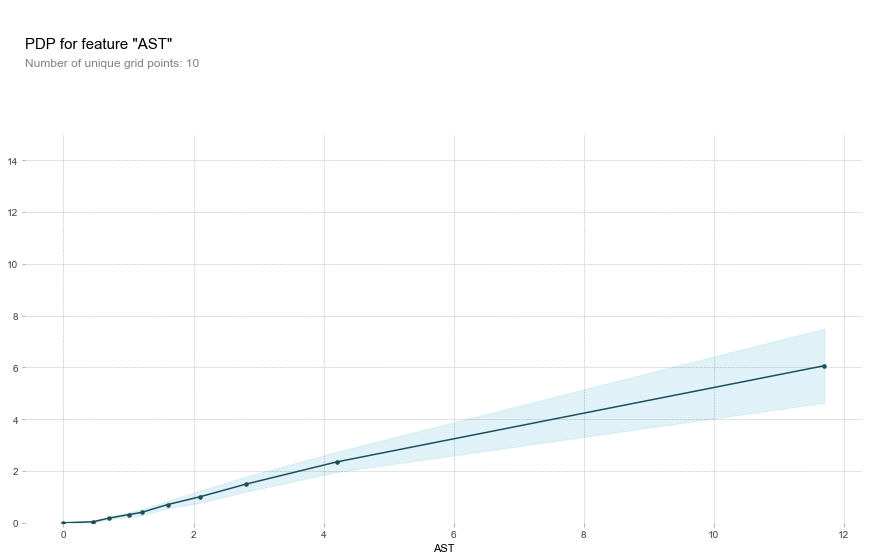

In [111]:
pdp_plot(isolated, feature_name=feature);

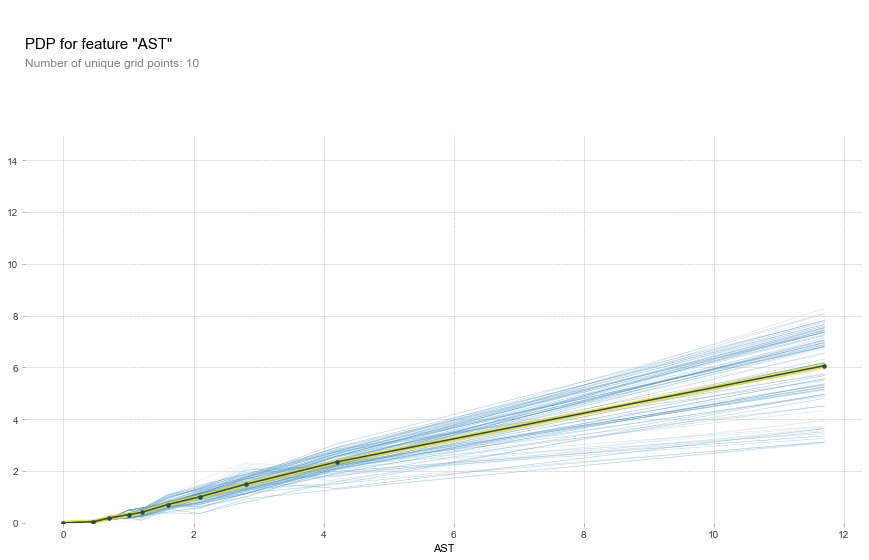

In [112]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100);

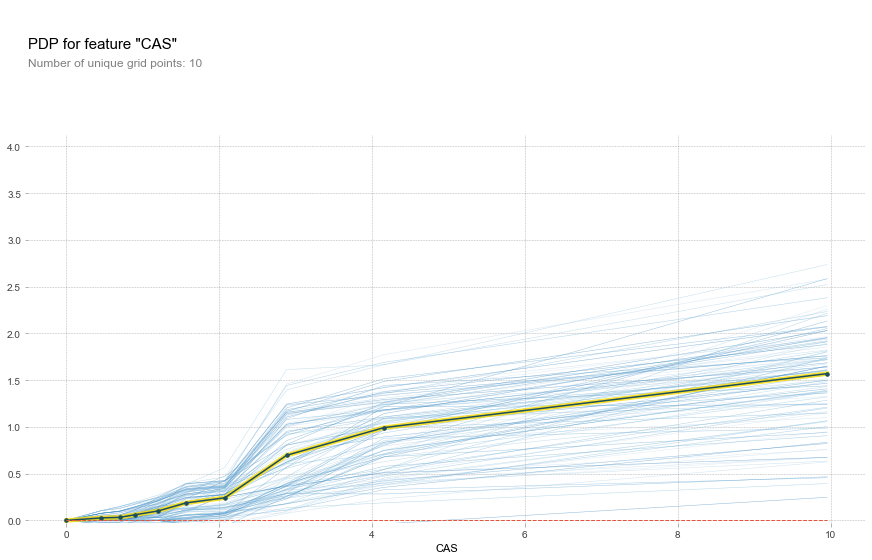

In [113]:
feature = 'CAS'

isolated = pdp_isolate(
    model=model,
    dataset=X_val_transformed,
    model_features=X_val_transformed.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100);

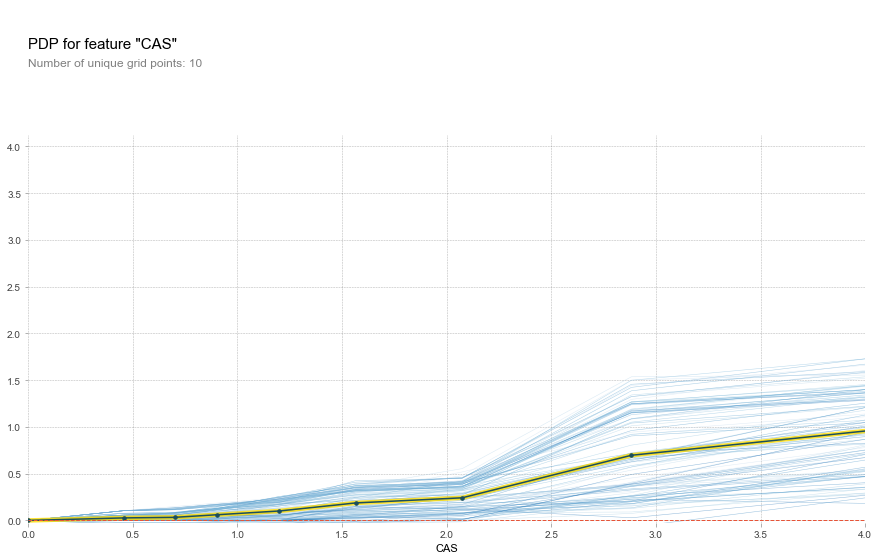

In [114]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.xlim(0, 4);

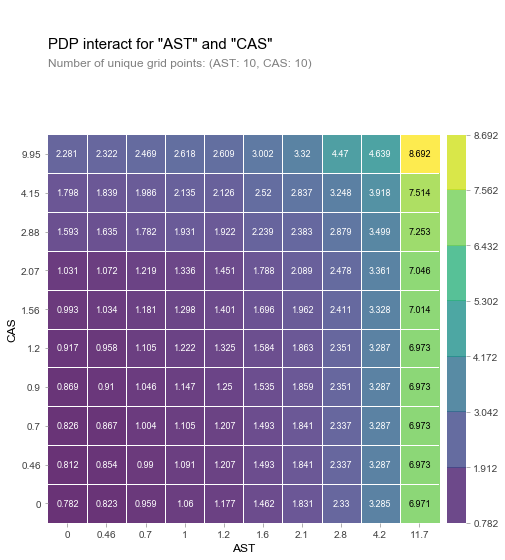

In [115]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['AST', 'CAS']

interaction = pdp_interact(
    model=model,
    dataset=X_val_transformed,
    model_features=X_val_transformed.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

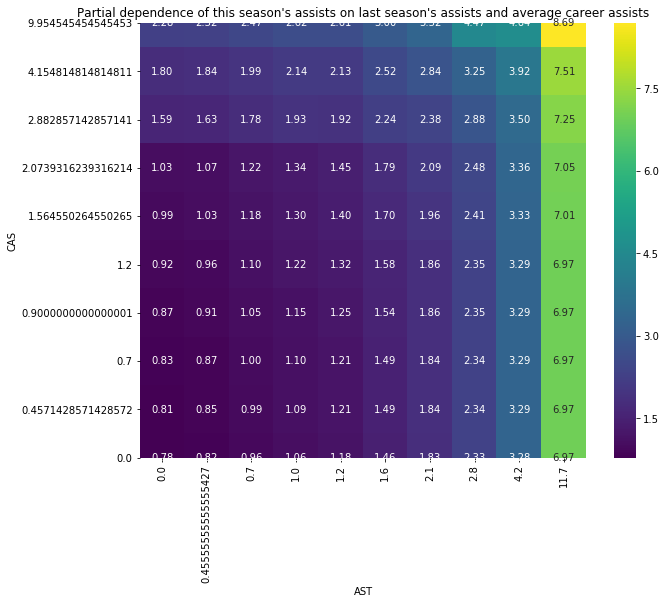

In [117]:
import seaborn as sns

pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features[1]
)[::-1]

plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title("Partial dependence of this season's assists on last season's assists and average career assists");

In [122]:
import plotly.graph_objs as go

surface = go.Surface(x=pdp.columns,
                    y=pdp.index,
                    z=pdp.values)

fig = go.Figure(surface)

fig.update_layout(scene = dict(
                    xaxis_title="Last season's assists",
                    yaxis_title="Average career assists",
                    zaxis_title="This season's assists"),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()